In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import io

**Task 1**

In [3]:
print("Data Loading and Exploration")

# load dataset
try:
    df = pd.read_csv('house_price_data.csv')
    print("dataset loaded successfully.")
except FileNotFoundError:
    print("file not found.")

# checking missing values and outliers
print("missing Values")
print(df.isnull().sum())

if 'Age' in df.columns and df['Age'].isnull().any():
    median_age = df['Age'].median()
    df['Age'].fillna(median_age, inplace=True)
    print("\nmissing 'age' values imputed with median.")

print("Summary Statistics")
print(df.describe())

Data Loading and Exploration
dataset loaded successfully.
missing Values
property_id                0
neighborhood               0
distance_to_city_center    0
distance_to_metro          0
distance_to_school         0
crime_rate                 0
house_age                  0
total_area                 0
bedrooms                   0
bathrooms                  0
floors                     0
garage                     0
garden                     0
basement                   0
balcony                    0
construction_quality       0
renovation_status          0
heating_type               0
air_conditioning           0
parking_spaces             0
energy_efficiency          0
listing_duration           0
season_sold                0
year_sold                  0
sale_price                 0
dtype: int64
Summary Statistics
       distance_to_city_center  distance_to_metro  distance_to_school  \
count              8000.000000        8000.000000         8000.000000   
mean                  3.

**Task 2**

Exploratory Data Analysis


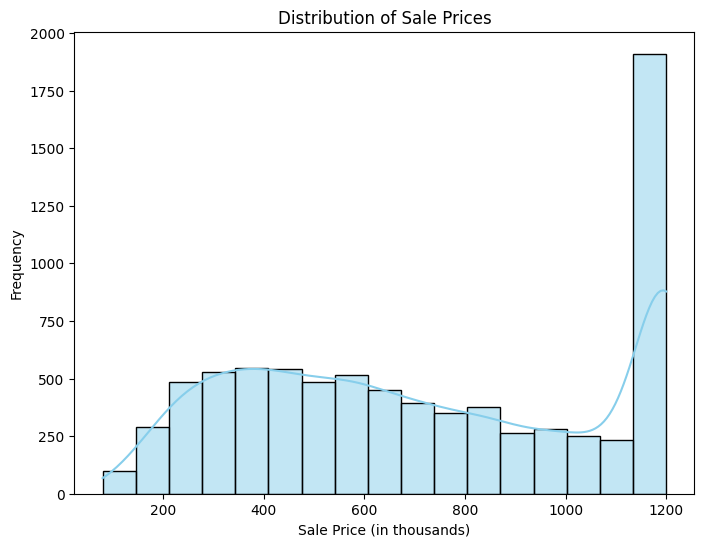

Skewness of Sale Price: 0.07


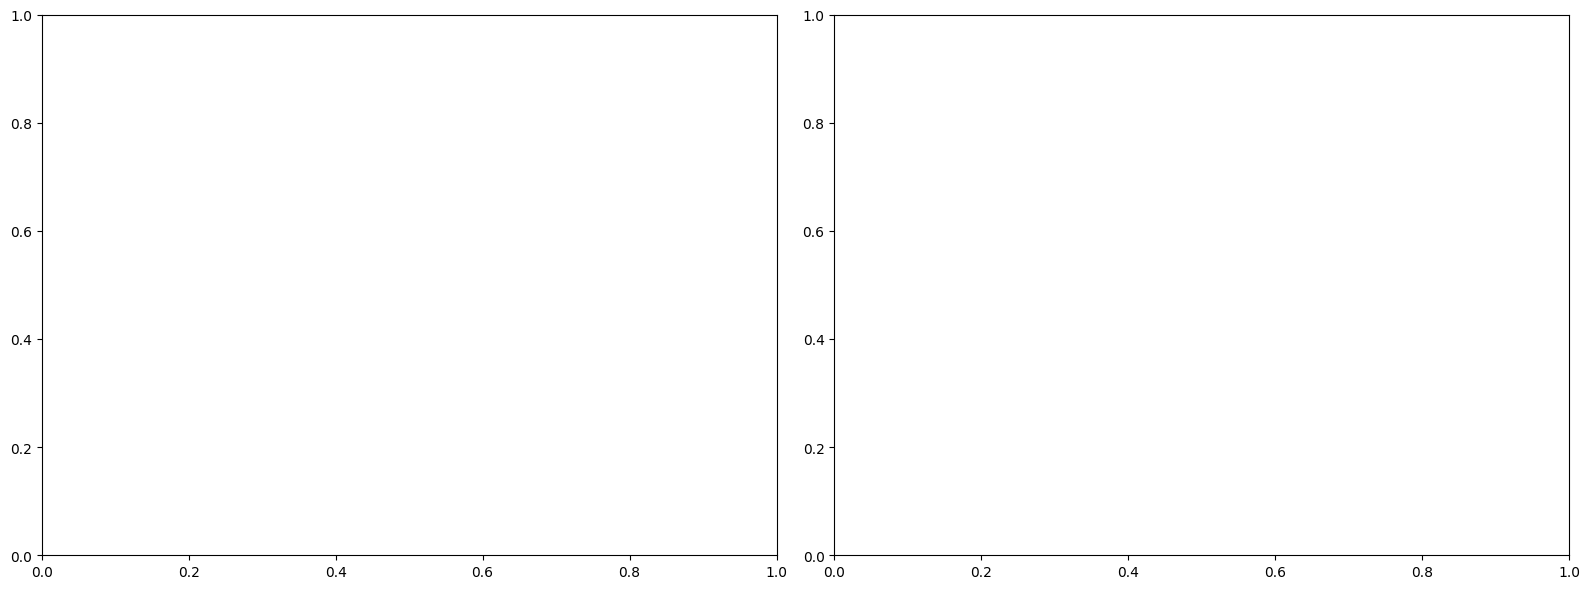

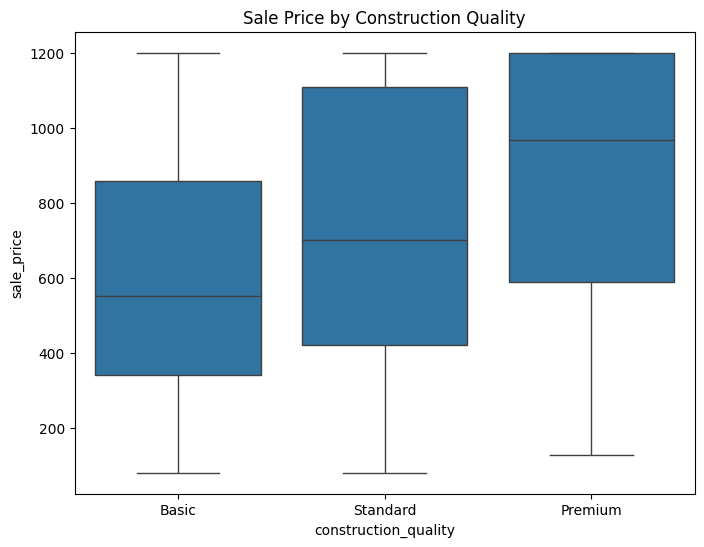

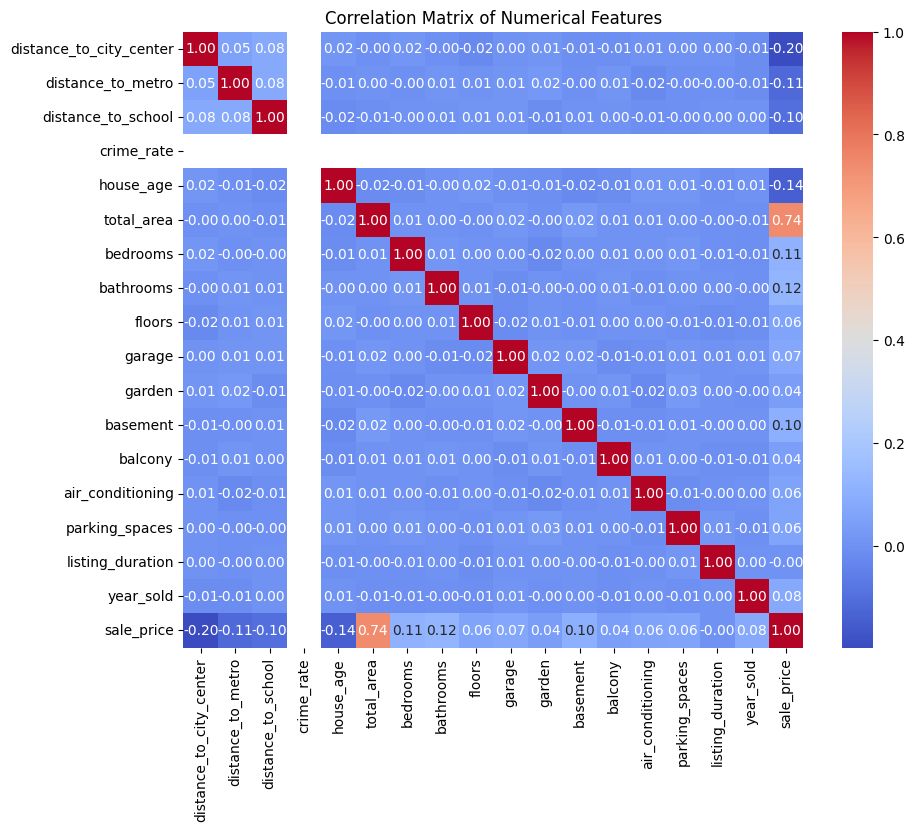

In [13]:
print("Exploratory Data Analysis")

# analyse price distribution and check for skewness
plt.figure(figsize=(8, 6))
sns.histplot(df['sale_price'], kde=True, color='skyblue')
plt.title('Distribution of Sale Prices')
plt.xlabel('Sale Price (in thousands)')
plt.ylabel('Frequency')
plt.show()
print(f"Skewness of Sale Price: {df['sale_price'].skew():.2f}")


# examine location impact and property feature relations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
if 'Neighbourhood' in df.columns:
    sns.boxplot(ax=axes[0], x='Neighbourhood', y='sale_price', data=df)
    axes[0].set_title('Sale Price by Neighbourhood')
if 'Bedrooms' in df.columns:
    sns.boxplot(ax=axes[1], x='Bedrooms', y='sale_price', data=df)
    axes[1].set_title('Sale Price by Number of Bedrooms')
plt.tight_layout()
plt.show()


# investigate quality factors, market timing effects
if 'construction_quality' in df.columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='construction_quality', y='sale_price', data=df)
    plt.title('Sale Price by Construction Quality')
    plt.show()


# create correlation analysis and identify multicollinearity
numerical_cols = df.select_dtypes(include=np.number).columns
correlation_matrix = df[numerical_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

**Task 3**

In [14]:
print("Feature Engineering and Preprocessing")

# handle categorical variables, create new features
df_processed = pd.get_dummies(df, drop_first=True)

# address outliers and multicollinearity issues
if 'Area' in df_processed.columns:
    p99 = df_processed['Area'].quantile(0.99)
    df_processed['Area'] = df_processed['Area'].clip(upper=p99)
    print(f"\nOutliers in 'Area' clipped at the 99th percentile ({p99}).")


# splieing thw data
X = df_processed.drop('sale_price', axis=1)
y = df_processed['sale_price']

# convert to tensors
X_tensor = torch.tensor(X.astype(np.float32).values)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

# manually doing min-max scaling for features
min_vals = X_tensor.min(dim=0, keepdim=True).values
max_vals = X_tensor.max(dim=0, keepdim=True).values
X_scaled = (X_tensor - min_vals) / (max_vals - min_vals)

# splitting data into training and testing (80 - 20)
torch.manual_seed(42)
indices = torch.randperm(len(X_scaled))
train_size = int(0.8 * len(X_scaled))

X_train, y_train = X_scaled[indices[:train_size]], y_tensor[indices[:train_size]]
X_test, y_test = X_scaled[indices[train_size:]], y_tensor[indices[train_size:]]

print(f"\nTrain set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Feature Engineering and Preprocessing

Train set shape: torch.Size([6400, 8045])
Test set shape: torch.Size([1600, 8045])


**Task 4**

In [15]:
print("Model Development")

# implementing the linear regression model
input_features = X_train.shape[1]
output_features = 1
learning_rate = 0.01
epochs = 1000

# model def
model_lin_reg = torch.nn.Linear(input_features, output_features)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model_lin_reg.parameters(), lr=learning_rate)

# training loop
for epoch in range(epochs):
    outputs = model_lin_reg(X_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Linear Regression - Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

print("\nLinear Regression training complete.")

Model Development
Linear Regression - Epoch [100/1000], Loss: nan
Linear Regression - Epoch [200/1000], Loss: nan
Linear Regression - Epoch [300/1000], Loss: nan
Linear Regression - Epoch [400/1000], Loss: nan
Linear Regression - Epoch [500/1000], Loss: nan
Linear Regression - Epoch [600/1000], Loss: nan
Linear Regression - Epoch [700/1000], Loss: nan
Linear Regression - Epoch [800/1000], Loss: nan
Linear Regression - Epoch [900/1000], Loss: nan
Linear Regression - Epoch [1000/1000], Loss: nan

Linear Regression training complete.


**Task 5**

Model Evaluation
Linear Regression Test Metrics
Mean Absolute Error (MAE): nan
Mean Squared Error (MSE): nan
Root Mean Squared Error (RMSE): nan
R-squared (R²): nan


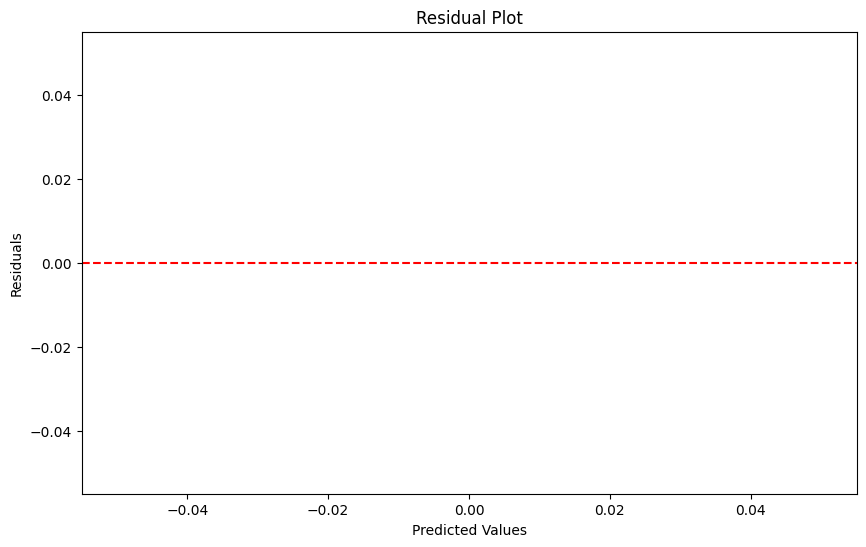

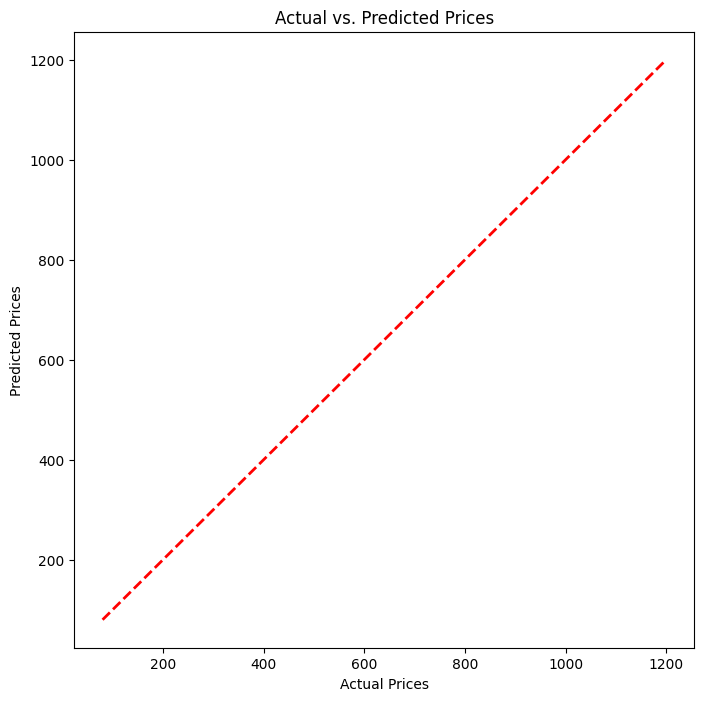

In [16]:
print("Model Evaluation")

# Evaluate using MAE, MSE, RMSE, R-squared
with torch.no_grad():
    y_pred = model_lin_reg(X_test)

    # manually calculating metrics
    mae = torch.mean(torch.abs(y_pred - y_test)).item()
    mse = torch.mean((y_pred - y_test)**2).item()
    rmse = torch.sqrt(torch.tensor(mse)).item()

    ss_total = torch.sum((y_test - torch.mean(y_test))**2)
    ss_residual = torch.sum((y_test - y_pred)**2)
    r2 = 1 - (ss_residual / ss_total)
    r2 = r2.item()

    print("Linear Regression Test Metrics")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R-squared (R²): {r2:.4f}")


# Create residual plots and compare model performances
residuals = (y_test - y_pred).numpy()
plt.figure(figsize=(10, 6))
plt.scatter(y_pred.numpy(), residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


# Select best model and validate on test set
plt.figure(figsize=(8, 8))
plt.scatter(y_test.numpy(), y_pred.numpy(), alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs. Predicted Prices')
plt.show()